In [1]:
import json
import numpy as np

In [2]:
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
import progressbar
from bert_serving.client import BertClient
bc = BertClient(ip='10.15.82.136')

In [4]:
root_folder = '/home/lyt/code/vqa-concept'
data_folder = '{}/dataTVQA'.format(root_folder)
fea_folder = '{}/image-feature/bottomup'.format(data_folder)
img_folder = '/home/data/lyt/TextVQA/train_images'
img_folder_test = '/home/data/lyt/TextVQA/test_images'
emb_size = 768
ocr_num = 50

In [5]:
#=======================================

In [6]:
split_name = 'val'
if split_name == 'test':
    img_folder = img_folder_test
jsdata = json.load(open('{}/TextVQA_0.5_{}.json'.format(data_folder, split_name),'r'))
print(jsdata.keys())

dict_keys(['dataset_type', 'dataset_name', 'dataset_version', 'data'])


In [7]:
for k in jsdata.keys():
    if k != 'data':
        print('{}: {}'.format(k,jsdata[k]))

dataset_type: val
dataset_name: textvqa
dataset_version: 0.5


In [8]:
data = jsdata['data']
print(len(data),type(data))

5000 <class 'list'>


In [9]:
pair = data[3]
pair.keys()

dict_keys(['question', 'image_id', 'image_classes', 'flickr_original_url', 'flickr_300k_url', 'image_width', 'image_height', 'answers', 'ocr_tokens', 'ocr_info', 'question_tokens', 'question_id', 'set_name'])

In [10]:
for k in pair.keys():
    if k != 'ocr_info':
        print('{}: {}'.format(k,pair[k]))

question: what brand liquor is on the right?
image_id: 831bcec304a17054
image_classes: ['Beer', 'Drink', 'Bottle', 'Wine']
flickr_original_url: https://farm5.staticflickr.com/5590/15223897342_cfd1371970_o.jpg
flickr_300k_url: https://c6.staticflickr.com/6/5590/15223897342_3cbf78f4c9_z.jpg
image_width: 1024
image_height: 576
answers: ['bowmore ', 'bowmore', 'bowmore', 'bowmore', 'bowmore', 'bowmore', 'bowmore', 'bowmore islay', 'dowmore islay', 'bowmore islay']
ocr_tokens: ['IGNET', 'OWMOR', 'MORANGIE', 'MORANGIE', 'EMORANGIE', 'ISLAY', 'SINGLE', 'MAIT', 'TCHWLS', 'MLANDS', 'ANTA', 'HISKY', 'SCOTCH', 'WEN!', 'NON', 'MATURED', 'SHERRY', 'CASKS', 'Batk.Rd', 'seNe', 'CAIKTIHE', 'FRSTALLBOURBON', 'BATONNS', '55.6%at', 'LONGHO', 'BLAY', 'CISTILLER', 'SCCILA', 'AND', 'AGED', '10']
question_tokens: ['what', 'brand', 'liquor', 'is', 'on', 'the', 'right']
question_id: 34605
set_name: val


In [11]:
print(len(pair['ocr_tokens']))
print(pair['ocr_tokens'])
ocr_info =  pair['ocr_info']
print(type(ocr_info))
print(ocr_info[0].keys())

31
['IGNET', 'OWMOR', 'MORANGIE', 'MORANGIE', 'EMORANGIE', 'ISLAY', 'SINGLE', 'MAIT', 'TCHWLS', 'MLANDS', 'ANTA', 'HISKY', 'SCOTCH', 'WEN!', 'NON', 'MATURED', 'SHERRY', 'CASKS', 'Batk.Rd', 'seNe', 'CAIKTIHE', 'FRSTALLBOURBON', 'BATONNS', '55.6%at', 'LONGHO', 'BLAY', 'CISTILLER', 'SCCILA', 'AND', 'AGED', '10']
<class 'list'>
dict_keys(['word', 'bounding_box'])


In [12]:
word = ocr_info[0]['word']
print(word)

IGNET


In [13]:
bbox = ocr_info[0]['bounding_box']
print(bbox)

{'top_left_x': 0.303052932024, 'top_left_y': 0.083134889602661, 'width': 0.15798400342464, 'height': 0.078694470226765, 'rotation': 0, 'yaw': 0, 'roll': 0, 'pitch': 0}


In [14]:
img = imread('{}/{}.jpg'.format(img_folder, pair['image_id']))

(576, 1024, 3)


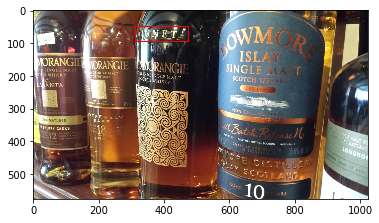

In [15]:
print(img.shape)
fig,ax = plt.subplots(1)
ax.imshow(img)
ax.add_patch(Rectangle((round(bbox['top_left_x']*pair['image_width']),round(bbox['top_left_y']*pair['image_height'])),
                       round(bbox['width']*pair['image_width']),round(bbox['height']*pair['image_height']),
                       linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

In [16]:
#------save im_id:ocr_information------

In [17]:
im_ocr = {}
for pair in data:
    im_id = pair['image_id']
    if im_id not in im_ocr:
        im_ocr[im_id] = {'image_classes': pair['image_classes'],
                         'image_width': pair['image_width'],
                         'image_height': pair['image_height'],
                         'ocr_tokens': pair['ocr_tokens'],
                         'ocr_info': pair['ocr_info']}
#json.dump(im_ocr, open('{}/ocr_{}.json'.format(data_folder, split_name),'w'))

In [18]:
len(im_ocr)

3166

In [19]:
im_ids = np.load('{}/{}_100_id.npy'.format(fea_folder, split_name))
print(im_ids.shape)

(3166,)


In [20]:
ocr_emb = np.random.randn(im_ids.shape[0], ocr_num, emb_size).astype('float32')
#ocr_emb = (ocr_emb + mean) * std
#ocr_emb = np.zeros((im_ids.shape[0], ocr_num, emb_size), dtype='float32')
bar = progressbar.ProgressBar(max_value=im_ids.shape[0]).start()
for i,imid in enumerate(im_ids):
    bar.update(i+1)
    all_ocr = im_ocr[imid]['ocr_tokens']
    all_ocr = [ocr for ocr in all_ocr if ocr != '']
    num = min(ocr_num,len(all_ocr))
    if num == 0:
        continue
    ocr_list = [all_ocr[j].strip().lower() for j in range(num)]
    curr_embs = bc.encode(ocr_list)
    ocr_emb[i][:num] = curr_embs
bar.finish()

100% (3166 of 3166) |#####################| Elapsed Time: 0:00:52 Time: 0:00:52


In [21]:
"""
ocr_emb = np.random.randn(im_ids.shape[0], ocr_num, emb_size).astype('float32')
i = 1
imid = im_ids[i]
all_ocr = im_ocr[imid]['ocr_tokens']
all_ocr = [ocr for ocr in all_ocr if ocr != '']
num = min(ocr_num,len(all_ocr))
if num == 0:
    print('num is 0')
else:
    ocr_list = [all_ocr[j].strip().lower() for j in range(num)]
    print(ocr_list)
    curr_embs = bc.encode(ocr_list)
    print(curr_embs.shape)
    ocr_emb[i][:num] = curr_embs
    print(ocr_emb[i][:num].shape)
    print(ocr_emb[i][:num])
"""

"\nocr_emb = np.random.randn(im_ids.shape[0], ocr_num, emb_size).astype('float32')\ni = 1\nimid = im_ids[i]\nall_ocr = im_ocr[imid]['ocr_tokens']\nall_ocr = [ocr for ocr in all_ocr if ocr != '']\nnum = min(ocr_num,len(all_ocr))\nif num == 0:\n    print('num is 0')\nelse:\n    ocr_list = [all_ocr[j].strip().lower() for j in range(num)]\n    print(ocr_list)\n    curr_embs = bc.encode(ocr_list)\n    print(curr_embs.shape)\n    ocr_emb[i][:num] = curr_embs\n    print(ocr_emb[i][:num].shape)\n    print(ocr_emb[i][:num])\n"

In [22]:
ocr_emb.shape

(3166, 50, 768)

In [23]:
np.save('{}/ocr_bert.new.{}/{}_{}_ocr.npy'.format(fea_folder, emb_size, split_name, ocr_num), ocr_emb)

In [24]:
#=======================================

In [25]:
bc.close()